# Tmn_x matrix integral computation : $\int \phi_m \partial_x \phi_n dz$



# Tmn_y matrix integral computation : $\int \phi_m \partial_y \phi_n dz$



# Anm_x background flow horizontal shear modal matrix : $\int \partial_x \Phi_k \Phi_n \Phi_m dz$



# Anm_y background flow horizontal shear modal matrix : $\int \partial_y \Phi_k \Phi_n \Phi_m dz$



# Anm_z background flow vertical shear modal matrix : $\int \partial_z \Phi_k \varphi_n \Phi_m dz$



# Bnm advection of p (buoyancy) modal matrix : $\int \frac{N^2_{steady}}{c^2_n} \Phi_k \varphi_n \varphi_m dz$
# Or  $-\int \Phi_k \partial_z \Phi_n \varphi_m dz$



# Bnm_x advection of Ns modal matrix: $ \int \partial_x(\frac{N^2_{steady}}{c^2_n} \varphi_n) \varphi_m \Phi_k dz$
# Or  $-\int \partial_x(\partial_z \Phi_n) \varphi_m \Phi_k dz$


# Bnm_y advection of Ns modal matrix: $ \int \partial_y(\frac{N^2_{steady}}{c^2_n} \varphi_n) \varphi_m \Phi_k dz$
# Or  $-\int \partial_y(\partial_z \Phi_n) \varphi_m \Phi_k dz$


# Bnm_z advection of Ns modal matrix: $ \int \partial_z(\frac{N^2_{steady}}{c^2_n} \varphi_n) \varphi_m \Phi_k dz$
# Or  $-\int \partial_z(\partial_z \Phi_n) \varphi_m \Phi_k dz$
 


In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import dask

from xgcm import Grid

from rechunker import rechunk

from pathlib import Path

import shutil

from Routines import utilities
from Routines import filtres

import Modal_matrix

In [2]:
from dask.distributed import Client, wait, LocalCluster
from dask_jobqueue import PBSCluster

if True:
    cluster = PBSCluster(walltime="06:00:00")
else:
    tmp_wrk = "/home/datawork-lops-osi/equinox/enatl60/adrien/tmp"
    cluster = LocalCluster(local_directory=tmp_wrk)
client = Client(cluster)
client 

<Client: 'tcp://10.148.1.93:46767' processes=0 threads=0, memory=0 B>

# LOADING INITIAL DATASET

In [3]:
%%time
cluster.scale(jobs=1)

grid = utilities.get_eNATL60_grid()

CPU times: user 144 ms, sys: 12 ms, total: 156 ms
Wall time: 308 ms


# Datapath

In [4]:
datapath_data_preprocessed = Path('/home/datawork-lops-osi/equinox/enatl60/adrien/data_preprocessed/')
datapath_result = Path('/home/datawork-lops-osi/equinox/enatl60/adrien/results/')
datapath_modes_corrections = Path('/home/datawork-lops-osi/equinox/enatl60/vmodes_and_global-mean/')
data_path_temp = Path('/home3/scratch/abella/temp/')
#data_path_temp = Path('/home/datawork-cersat-public/cache/users/inria/temp')

# Parametre

In [5]:
Month = 10


# DOMAIN

# need the .5 at the superior end because of x_r and y_r, if you want then to have the same number of point as x_c and y_c
Domain_Sahara_dict = dict(x=slice(4200, 5200.5), y=slice(400,1400.5))
Domain_Caraibe_dict = dict(x=slice(1100, 2300.5), y=slice(300,1100.5))
Domain_Gulfstream_dict = dict(x=slice(1300, 2800.5), y=slice(1800,2700.5))
Domain_Azores_dict = dict(x=slice(3600, 4500.5), y=slice(1400,2300.5))
Domain_North_Atlantic_dict = dict(x=slice(0,8354.5), y=slice(0,4729.5))
Domain_Bay_of_Biscay_dict = dict(x=slice(4600, 5800.5), y=slice(2400,3200.5))
Domain_Nordic_Europe_dict = dict(x=slice(4600,5600.5), y=slice(3300,4600.5))
Domain_Labrador_dict = dict(x=slice(1900, 3400.5), y=slice(3600,4700.5))

Dict_domain = ({'Gulf_Stream' : Domain_Gulfstream_dict, 'Azores' : Domain_Azores_dict, 'North_Atlantic' : Domain_North_Atlantic_dict, 
                'Nordic_Europe' : Domain_Nordic_Europe_dict, 'Sahara' : Domain_Sahara_dict, 'Caraibe' : Domain_Caraibe_dict,
               'Bay_of_Biscay' : Domain_Bay_of_Biscay_dict, 'Labrador' : Domain_Labrador_dict})

    

#Domain = 'Azores'
Domain = 'Gulf_Stream'
#Domain = 'North_Atlantic'
#Domain = 'Nordic_Europe'
#Domain = 'Sahara'
#Domain = 'Caraibe'
#Domain = 'Bay_of_Biscay'
#Domain = 'Labrador'

# CHUNKING

In [6]:
### CHUNKING PARAMETERS
ch_h_main = 100
ch_v_main = 20
ch_t_main = 31
ch_mode = -1


grid = utilities.Domain_selection(grid, Domain, Dict_domain)
grid = grid.chunk({'x_c' : ch_h_main, 'x_r' : ch_h_main, 'y_c' : ch_h_main, 'y_r' : ch_h_main, 'z_c' : ch_v_main, 'z_l' : ch_v_main})



max_mem = '3GB' #Max of memory per core allocated to the rechunking operation. 
#Do not excess the worker RAM capacity (nor get too near) 4 core by worker. So max 3GB

# Xgrid building

In [7]:
Aps = xr.open_zarr(datapath_data_preprocessed/"Aus_corr_month_{}.zarr".format(Month))
Aps = utilities.Domain_selection(Aps, Domain, Dict_domain)


DataGrid = xr.merge([grid, Aps])
xgrid = Grid(DataGrid, periodic=None)

# Modal matrix

## Tmn

In [8]:
%%time
   

cluster.scale(jobs=2)


Dataset = xr.open_zarr(datapath_modes_corrections/"eNATL60_global-mean_vmodes.zarr")
Dataset = utilities.Domain_selection(Dataset, Domain, Dict_domain)
Phi = Dataset.phi.reset_coords(drop=True).astype(dtype=np.float32)
Phi = Phi.chunk({"x_c":ch_h_main*2, "y_c":ch_h_main*2})


e3t = grid.e3t.reset_coords(drop=True).astype(dtype=np.float32)
e2v = grid.e2v.reset_coords(drop=True).astype(dtype=np.float32)
e1u = grid.e1u.reset_coords(drop=True).astype(dtype=np.float32)

Modal_matrix.Tmn_integral(Phi, e1u, e2v, e3t, ch_h_main, ch_v_main, ch_h_main*2, ch_v_main*2, datapath_data_preprocessed, data_path_temp, xgrid, max_mem)


/home3/datahome/abella/internal_tide_north_atlantic_datarmor/Modal_matrix.py:47: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  Phi = xr.open_zarr(datapath_temp/"Phi_prov_initial.zarr")
/home3/datahome/abella/internal_tide_north_atlantic_datarmor/Modal_matrix.py:60: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing

0
200
400
600
800
0
200
400
600
800
CPU times: user 6min 19s, sys: 12.6 s, total: 6min 32s
Wall time: 14min 11s


# Matrix of first part of uv advection term.

In [10]:
%%time
cluster.scale(jobs=4)


Dataset = xr.open_zarr(datapath_modes_corrections/"eNATL60_global-mean_vmodes.zarr")
Dataset = utilities.Domain_selection(Dataset, Domain, Dict_domain)
Phi = Dataset.phi.reset_coords(drop=True)

e3t = grid.e3t.reset_coords(drop=True)


Anm = Modal_matrix.Advection_uv_P1_matrix(Phi, ch_h_main, ch_v_main, ch_h_main*2, ch_v_main*2, e3t, datapath_data_preprocessed, data_path_temp, max_mem)

step = 100

utilities.storage_by_step(Anm, 'Anm', 'Advection_uv_matrix.zarr', step, {"x_c":ch_h_main*2, 'y_c':ch_h_main*2}, datapath_data_preprocessed)
shutil.rmtree(data_path_temp/'Phi_prov_initial.zarr')
shutil.rmtree(data_path_temp/'Phi_prov_initial_secundus.zarr')

/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/worker.py:3029: UserWarning: Large object of size 3.80 MiB detected in task graph: 
  ("('copy_read_to_intermediate-98824a3deb5440736d31 ... 9004', 38050)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
/dev/shm/pbs.5822506.datarmor0/ipykernel_14816/1606356341.py:21: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Expli

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
CPU times: user 1h 19min 23s, sys: 3min 48s, total: 1h 23min 12s
Wall time: 2h 46min 57s


# Matrix of advection of p (buoyancy) term Bnm

In [10]:
%%time


cluster.scale(jobs=4)


Dataset = xr.open_zarr("/home/datawork-cersat-public/cache/users/inria/vmodes_30d-mean/eNATL60_30d-mean_vmodes_20090928.zarr")
Dataset = utilities.Domain_selection(Dataset, Domain, Dict_domain)
Phiw = Dataset.phiw.reset_coords(drop=True).astype(dtype=np.float32)
Phi = Dataset.phi.reset_coords(drop=True).astype(dtype=np.float32)
dc = Dataset.c.reset_coords(drop=True).astype(dtype=np.float32)

Dataset = xr.open_zarr(datapath_modes_corrections/"eNATL60_global-mean_bvf.zarr")
Dataset = utilities.Domain_selection(Dataset, Domain, Dict_domain)
Ns = Dataset.bvf.reset_coords(drop=True).astype(dtype=np.float32)

e3w = grid.e3w.reset_coords(drop=True).astype(dtype=np.float32)


#Bnm = Modal_matrix.pressure_advection_matrix(Ns, Phiw, Phi, dc, e3w, ch_h_main, ch_v_main, ch_h_main*2, ch_v_main*2, xgrid, datapath_data_preprocessed, data_path_temp, max_mem)
Bnm = Modal_matrix.pressure_advection_matrix_without_N_dc(Phiw, Phi, e3w, ch_h_main, ch_v_main, ch_h_main*2, ch_v_main*2, xgrid, datapath_data_preprocessed, data_path_temp, max_mem)



step = 100

utilities.storage_by_step(Bnm, 'Bnm', "Advection_p_matrix.zarr", step, {"x_c":ch_h_main*2, "y_c":ch_h_main*2, 'mode':-1, 'modk':-1}, datapath_data_preprocessed)


shutil.rmtree(data_path_temp/'Phi_prov.zarr')
#shutil.rmtree(data_path_temp/'Phim_prov.zarr')
shutil.rmtree(data_path_temp/'Phiw_prov.zarr')

/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/worker.py:3029: UserWarning: Large object of size 1.62 MiB detected in task graph: 
  ("('copy_read_to_intermediate-21a7f9a400d7b4215b53 ... 4b2a3d', 259)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
/dev/shm/pbs.6062085.datarmor0/ipykernel_23514/3962227278.py:24: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Expli

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
CPU times: user 1h 30min 38s, sys: 2min 51s, total: 1h 33min 29s
Wall time: 2h 32min 17s


# Vertical shear coupling matrix

In [ ]:
%%time
cluster.scale(jobs=4)


ch_h_main = 100
ch_v_main = 20



Dataset = xr.open_zarr(datapath_modes_corrections/"eNATL60_global-mean_vmodes.zarr")
Dataset = utilities.Domain_selection(Dataset, Domain, Dict_domain)
Phi = Dataset.phi.reset_coords(drop=True).astype(dtype=np.float32)
Phiw = Dataset.phiw.reset_coords(drop=True).astype(dtype=np.float32)


e3w = grid.e3w.reset_coords(drop=True).astype(dtype=np.float32)
e3w = e3w.chunk({'x_c': ch_h_main, 'y_c': ch_h_main, 'z_l': ch_v_main})


Anm_z = Modal_matrix.vertical_shear_matrix(Phi, Phiw, e3w, xgrid, ch_h_main, ch_v_main, ch_h_main*2, ch_v_main*2, data_path_temp, max_mem)


step = 100
utilities.storage_by_step(Anm_z, 'Anm_z', "Vertical_shear_matrix.zarr", step, {"x_c":ch_h_main*2, "y_c":ch_h_main*2, 'mode':-1, 'modk':-1}, datapath_data_preprocessed)

shutil.rmtree(data_path_temp/'Phi_prov.zarr')
shutil.rmtree(data_path_temp/'Phi_z_prov.zarr')
shutil.rmtree(data_path_temp/'Phiw_prov.zarr')

# Horizontal shear coupling matrix X

In [9]:
%%time


cluster.scale(jobs=4)


Dataset = xr.open_zarr(datapath_modes_corrections/"eNATL60_global-mean_vmodes.zarr")
Dataset = utilities.Domain_selection(Dataset, Domain, Dict_domain)
Phi = Dataset.phi.reset_coords(drop=True).astype(dtype=np.float32)


e3t = grid.e3t.reset_coords(drop=True).chunk({'x_c': ch_h_main, 'y_c': ch_h_main}).astype(dtype=np.float32)
e1u = grid.e1u.reset_coords(drop=True).chunk({'x_r': ch_h_main, 'y_c': ch_h_main}).astype(dtype=np.float32)


Anm_x = Modal_matrix.horizontal_shear_matrix_X(Phi, e3t, e1u, xgrid, ch_h_main, ch_v_main, ch_h_main*2, ch_v_main*2, data_path_temp, max_mem)


step = 100
utilities.storage_by_step(Anm_x, 'Anm_x', "Horizontal_shear_matrix_X.zarr", step, {"x_c":ch_h_main*2, "y_c":ch_h_main*2, 'mode':-1, 'modk':-1}, datapath_data_preprocessed)


shutil.rmtree(data_path_temp/'Phi_prov_x_secundus.zarr')
shutil.rmtree(data_path_temp/'Phi_prov_initial.zarr')

/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/worker.py:3029: UserWarning: Large object of size 1.62 MiB detected in task graph: 
  ("('copy_read_to_intermediate-98e363597f55cdb3439b ... f98d3', 5821)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
/dev/shm/pbs.5918465.datarmor0/ipykernel_33067/3719133007.py:23: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Expli

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
CPU times: user 24min 55s, sys: 43.7 s, total: 25min 39s
Wall time: 1h 11min 49s


# Horizontal shear coupling matrix Y

In [9]:
%%time


cluster.scale(jobs=4)


Dataset = xr.open_zarr(datapath_modes_corrections/"eNATL60_global-mean_vmodes.zarr")
Dataset = utilities.Domain_selection(Dataset, Domain, Dict_domain)
Phi = Dataset.phi.reset_coords(drop=True).astype(dtype=np.float32)


e3t = grid.e3t.reset_coords(drop=True).chunk({'x_c': ch_h_main, 'y_c': ch_h_main}).astype(dtype=np.float32)
e2v = grid.e2v.reset_coords(drop=True).chunk({'x_c': ch_h_main, 'y_r': ch_h_main}).astype(dtype=np.float32)


Anm_y = Modal_matrix.horizontal_shear_matrix_Y(Phi, e3t, e2v, xgrid, ch_h_main, ch_v_main, ch_h_main*2, ch_v_main*2, data_path_temp, max_mem)


step = 100
utilities.storage_by_step(Anm_y, 'Anm_y', "Horizontal_shear_matrix_Y.zarr", step, {"x_c":ch_h_main*2, "y_c":ch_h_main*2, 'mode':-1, 'modk':-1}, datapath_data_preprocessed)

shutil.rmtree(data_path_temp/'Phi_prov_y_secundus.zarr')
shutil.rmtree(data_path_temp/'Phi_prov_initial.zarr')

/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/worker.py:3029: UserWarning: Large object of size 1.62 MiB detected in task graph: 
  ("('copy_read_to_intermediate-16094033c29efe83ac36 ... cde46', 1686)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
/dev/shm/pbs.5918465.datarmor0/ipykernel_19414/4189787143.py:22: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Expli

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
CPU times: user 24min 31s, sys: 38.3 s, total: 25min 9s
Wall time: 1h 11min


# Advection of Ns by the background flow 

In [10]:
%%time
cluster.scale(jobs=4)




Dataset = xr.open_zarr(datapath_modes_corrections/"eNATL60_global-mean_vmodes.zarr")
Dataset = utilities.Domain_selection(Dataset, Domain, Dict_domain)
Phi = Dataset.phi.reset_coords(drop=True).astype(dtype=np.float32)
#Phi = Phi.chunk({'x_c':ch_h_main, 'y_c':ch_h_main, 'z_c':ch_v_main*2, 'mode':1})
Phiw = Dataset.phiw.reset_coords(drop=True).astype(dtype=np.float32)
#Phiw = Phiw.chunk({'x_c':ch_h_main, 'y_c':ch_h_main, 'z_l':ch_v_main*2, 'mode':1})



e3t = grid.e3t.reset_coords(drop=True).chunk({'x_c': ch_h_main, 'y_c': ch_h_main}).astype(dtype=np.float32)
e2v = grid.e2v.reset_coords(drop=True).chunk({'x_c': ch_h_main, 'y_r': ch_h_main}).astype(dtype=np.float32)
e1u = grid.e1u.reset_coords(drop=True).chunk({'x_r': ch_h_main, 'y_c': ch_h_main}).astype(dtype=np.float32)
e3w = grid.e3w.reset_coords(drop=True).chunk({'x_c': ch_h_main, 'y_c': ch_h_main}).astype(dtype=np.float32)






Bnm_x, Bnm_y, Bnm_z = Modal_matrix.Advection_Ns_matrix_without_Ns(Phi, Phiw, e1u, e2v, e3t, e3w, ch_h_main, ch_v_main, ch_h_main*2, ch_v_main*2, data_path_temp, max_mem, xgrid)

shutil.rmtree(data_path_temp/'Phi_prov_secundus.zarr')
shutil.rmtree(data_path_temp/'Phi_z_prov.zarr')
shutil.rmtree(data_path_temp/'Phiw_prov.zarr')

shutil.rmtree(data_path_temp/"Ng_x.zarr")
shutil.rmtree(data_path_temp/"Ng_y.zarr")
shutil.rmtree(data_path_temp/"Ng_z.zarr")

/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/worker.py:3029: UserWarning: Large object of size 1.62 MiB detected in task graph: 
  ("('copy_read_to_intermediate-6452beb86582dfebd563 ... dc01b', 5127)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
/home3/datahome/abella/internal_tide_north_atlantic_datarmor/Modal_matrix.py:649: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate meta

NameError: name 'datapath_temp' is not defined

In [9]:
%%time
cluster.scale(jobs=4)

step = 100
utilities.storage_by_step(Bnm_x, 'Bnm_x', "Advection_Nsteady_matrix_X.zarr", step, {"x_c":ch_h_main*2, "y_c":ch_h_main*2, 'mode':-1, 'modk':-1}, datapath_data_preprocessed)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
CPU times: user 29min 30s, sys: 1min 8s, total: 30min 39s
Wall time: 1h 47min 26s


In [10]:
%%time
cluster.scale(jobs=4)

step = 100
utilities.storage_by_step(Bnm_y, 'Bnm_y', "Advection_Nsteady_matrix_Y.zarr", step, {"x_c":ch_h_main*2, "y_c":ch_h_main*2, 'mode':-1, 'modk':-1}, datapath_data_preprocessed)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
CPU times: user 30min 55s, sys: 1min 12s, total: 32min 8s
Wall time: 1h 48min 34s


In [16]:
Bnm_z.to_dataset(name='Bnm_z').to_zarr(datapath_data_preprocessed/"Advection_Nsteady_matrix_Z.zarr", compute=True, mode='w')

/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 58.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


RuntimeError: Error during deserialization of the task graph. This frequently occurs if the Scheduler and Client have different environments. For more information, see https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [13]:
%%time
cluster.scale(jobs=4)

step = 100
utilities.storage_by_step(Bnm_z, 'Bnm_z', "Advection_Nsteady_matrix_Z.zarr", step, {"x_c":ch_h_main*2, "y_c":ch_h_main*2, 'mode':-1, 'modk':-1}, datapath_data_preprocessed)

0


RuntimeError: Error during deserialization of the task graph. This frequently occurs if the Scheduler and Client have different environments. For more information, see https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


# Tmn perturbation H

In [25]:
%%time
cluster.scale(jobs=2)

ch_h_main = 200


Dataset = xr.open_zarr(datapath_modes_corrections/"eNATL60_global-mean_vmodes.zarr")
Dataset = utilities.Domain_selection(Dataset, Domain, Dict_domain) 
Phi = Dataset.phi.reset_coords(drop=True).astype(dtype=np.float32)
dc = Dataset.c.reset_coords(drop=True).astype(dtype=np.float32)
H = Dataset.norm.reset_coords(drop=True).astype(dtype=np.float32)


e2v = grid.e2v.reset_coords(drop=True).chunk({'x_c': ch_h_main, 'y_r': ch_h_main}).astype(dtype=np.float32)
e1u = grid.e1u.reset_coords(drop=True).chunk({'x_r': ch_h_main, 'y_c': ch_h_main}).astype(dtype=np.float32)
tmask = grid.tmask.chunk({'x_c': ch_h_main, 'y_c': ch_h_main})
dc = dc.chunk({'x_c': ch_h_main, 'y_c': ch_h_main, 'mode':-1})




CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 191 ms


In [28]:
%%time
cluster.scale(jobs=2)
Modal_matrix.Tmn_perturb_H_x(Phi, H, e1u, tmask, dc, ch_h_main, datapath_data_preprocessed, xgrid)

0


/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 36.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


200


/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 36.03 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


400


/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 36.03 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


600


/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 36.03 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


800


/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/distributed/client.py:3084: UserWarning: Sending large graph of size 17.57 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 2min 31s, sys: 2.02 s, total: 2min 33s
Wall time: 2min 47s


In [ ]:
%%time
cluster.scale(jobs=2)
Modal_matrix.Tmn_perturb_H_y(Phi, H, e2v, tmask, dc, ch_h_main, datapath_data_preprocessed)

# Tmn perturbation N

In [ ]:
%%time
cluster.scale(jobs=2)

Domain = "Gulf_Stream"

### Load daily-averaged rhoi
ch_h_main = 100
ch_v_main = 75

from datetime import datetime

datawork_lops_osi = Path("/home/datawork-lops-osi/equinox/enatl60")

file_path_rhomoy = datapath_modes_corrections/"eNATL60_global-mean_rho.zarr"
data_path_rhoday = datawork_lops_osi/"daily_means"

def get_rhoi_path(ymd):
    """ construct path for daily-averaged rho dataset """
    y, m = ymd[:4], ymd[4:6]
    filepath = f"rhoi_y{y}m{m}/daily_mean_rhoi_{ymd}.zarr"
    return data_path_rhoday/filepath

def open_and_put_date(datestr):
    """ open daily-averaged rhoi zarr and assign date as new dim """
    ds = xr.open_zarr(get_rhoi_path(datestr))
    ### WARNING: inconsistent chunks between some rhoi files
    # print(ut.get_chunks(ds.rhoinsitu))
    date = datetime.strptime(datestr+" 12", "%Y%m%d %H")
    return ds.expand_dims(t=[date])

### This takes some time (opening / checking all datasets)

Aps = xr.open_zarr(datapath_data_preprocessed/"Aps_final_month_{}.zarr".format(Month))
Aps = Aps.Ap_filtre.chunk({"x_c":ch_h_main*2, "y_c":ch_h_main*2})
dates = np.unique(Aps.t.dt.strftime("%Y%m%d"))
rho = xr.concat([open_and_put_date(d) for d in dates], dim="t")
rho = rho.rhoinsitu
rho = utilities.Domain_selection(rho, Domain, Dict_domain)
rho = rho.reset_coords(drop=True)
step = 200
rho = rho.mean(dim='t', skipna=True)
#utilities.storage_by_step(rho, 'rho', "rho_mean.zarr", step, {"x_c":ch_h_main*2, "y_c":ch_h_main*2, "z_c":ch_v_main*2}, data_path_temp)


Rho = xr.open_zarr(data_path_temp/"rho_mean.zarr")
rhomean = Rho.rho

Rho0 = 1026


e3w = grid.e3w.reset_coords(drop=True).chunk({'x_c': ch_h_main, 'y_c': ch_h_main, 'z_l':ch_v_main}).astype(dtype=np.float32)

Nmean = rhomean * Rho0
Nmean = xgrid.diff(Nmean, "Z", boundary="extend").chunk({"z_l":ch_v_main})/e3w
Nmean = Nmean.chunk({'z_l': ch_v_main, "x_c": ch_h_main*4, "y_c": ch_h_main*4})
#Nmean.to_dataset(name='Nt').to_zarr(data_path_temp/"Nt.zarr", compute=True, mode='w')









In [12]:
%%time
cluster.scale(jobs=2)

ch_h_main = 200
ch_v_main = 100

Dataset = xr.open_zarr(datapath_modes_corrections/"eNATL60_global-mean_bvf.zarr")
Dataset = utilities.Domain_selection(Dataset, Domain, Dict_domain)
Ns = Dataset.bvf.reset_coords(drop=True).astype(dtype=np.float32)
Nt = Ns.chunk({"x_c":ch_h_main, "y_c":ch_h_main, "z_l":ch_v_main})

 
g = 9.81
Nt = g*Nt 

Nt

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 21.3 ms


<xarray.DataArray 'bvf' (z_l: 300, y_c: 901, x_c: 1501)>
dask.array<mul, shape=(300, 901, 1501), dtype=float32, chunksize=(100, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * x_c      (x_c) int64 1300 1301 1302 1303 1304 ... 2796 2797 2798 2799 2800
  * y_c      (y_c) int64 1800 1801 1802 1803 1804 ... 2696 2697 2698 2699 2700
  * z_l      (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 295.5 296.5 297.5 298.5 299.5

In [13]:



Nt.to_dataset(name='Nt').to_zarr(data_path_temp/"Nt.zarr", compute=True, mode='w')
    


e2v = grid.e2v.reset_coords(drop=True).chunk({'x_c': ch_h_main, 'y_r': ch_h_main}).astype(dtype=np.float32)
e1u = grid.e1u.reset_coords(drop=True).chunk({'x_r': ch_h_main, 'y_c': ch_h_main}).astype(dtype=np.float32)
e3w = grid.e3w.reset_coords(drop=True).chunk({'x_c': ch_h_main, 'y_c': ch_h_main, 'z_l':ch_v_main}).astype(dtype=np.float32)


N_x = xgrid.diff(Nt, "X", boundary="extend").chunk({"x_r":ch_h_main})/e1u
N_x = xgrid.interp(N_x, "X", boundary="extend").chunk({"x_c":ch_h_main})
#N_y = xgrid.diff(Nt, "Y", boundary="extend").chunk({"y_r":ch_h_main})/e2v
#N_y = xgrid.interp(N_y, "Y", boundary="extend").chunk({"y_c":ch_h_main})



Dataset = xr.open_zarr(datapath_modes_corrections/"eNATL60_global-mean_vmodes.zarr")
Dataset = utilities.Domain_selection(Dataset, Domain, Dict_domain) 
dc = Dataset.c.reset_coords(drop=True)
dc = dc.chunk({"x_c":ch_h_main, "y_c":ch_h_main, 'mode':1})

Phi = Dataset.phi.reset_coords(drop=True).astype(dtype=np.float32)

Phiz = xgrid.diff(Phi, "Z", boundary="extend").chunk({"z_l":ch_v_main})/e3w



Tmn_x = -dc.rename({"mode":"modm"})**2*N_x/(Nt*Nt)*Phiz*Phiz.rename({"mode":"modm"})*e3w
Tmn_x = Tmn_x.sum("z_l")

Tmn_x = Tmn_x.chunk({"x_c":ch_h_main*2, "y_c":ch_h_main*2, "mode":-1, "modm":-1})
Tmn_x.to_dataset(name='Tmn_x').to_zarr(data_path_temp/"Tmn_x_N.zarr", compute=True, mode='w')

/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/home1/datahome/nlahaye/miniconda3/envs/nemo/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


In [19]:
Tmn_x_H

<xarray.DataArray 'Tmn_x' (mode: 11, modm: 11, y_c: 901, x_c: 1501)>
dask.array<open_dataset-da4c86166fb443170684b305ce6e006cTmn_x, shape=(11, 11, 901, 1501), dtype=float32, chunksize=(11, 11, 200, 400), chunktype=numpy.ndarray>
Dimensions without coordinates: mode, modm, y_c, x_c

In [12]:
Tmn_x

<xarray.DataArray 'TmnX' (y_c: 901, x_c: 1501, mode: 11, modm: 11)>
dask.array<open_dataset-b6367ea0ec5ed1d43b8bdbc7a30cf251TmnX, shape=(901, 1501, 11, 11), dtype=float32, chunksize=(200, 200, 1, 11), chunktype=numpy.ndarray>
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * modm     (modm) int64 0 1 2 3 4 5 6 7 8 9 10
  * x_c      (x_c) int64 1300 1301 1302 1303 1304 ... 2796 2797 2798 2799 2800
  * y_c      (y_c) int64 1800 1801 1802 1803 1804 ... 2696 2697 2698 2699 2700

In [14]:
%%time
cluster.scale(jobs=2)

Tmn_x_N = xr.open_zarr(data_path_temp/"Tmn_x_N.zarr")
Tmn_x_N = Tmn_x_N.Tmn_x.isel(mode=1, modm=2)


Tmn_x_H = xr.open_zarr(datapath_data_preprocessed/"Tmn_x_perturb_H.zarr")
Tmn_x_H = Tmn_x_H.Tmn_x.isel(mode=1, modm=2)


Tmn_x = xr.open_zarr(datapath_data_preprocessed/"Tmn_x.zarr")
Tmn_x = Tmn_x.TmnX.isel(mode=1, modm=2)



CPU times: user 48 ms, sys: 12 ms, total: 60 ms
Wall time: 106 ms


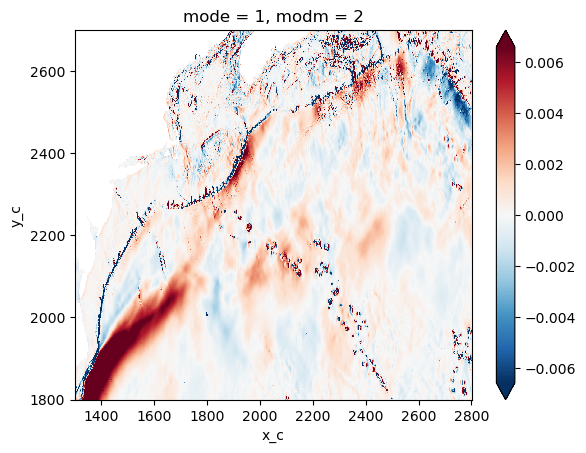

In [15]:
(Tmn_x - Tmn_x_H - Tmn_x_N).plot(robust=True)

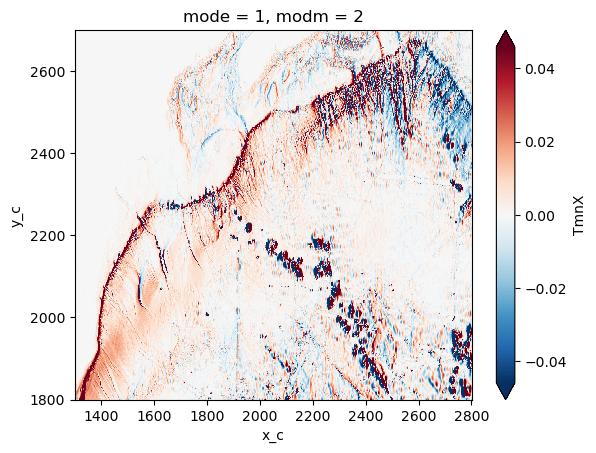

In [16]:
Tmn_x.plot(robust=True)

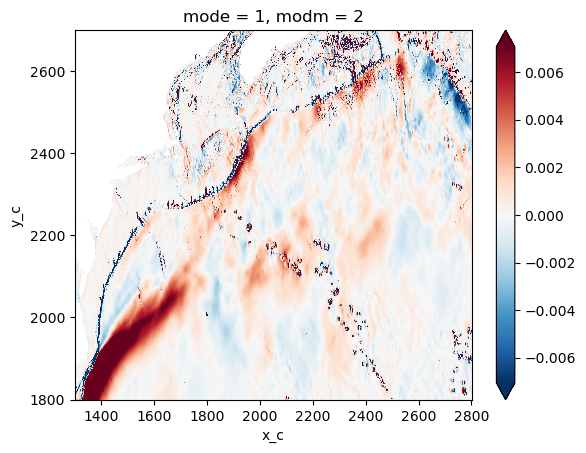

In [17]:
(Tmn_x - Tmn_x_H).plot(robust=True)

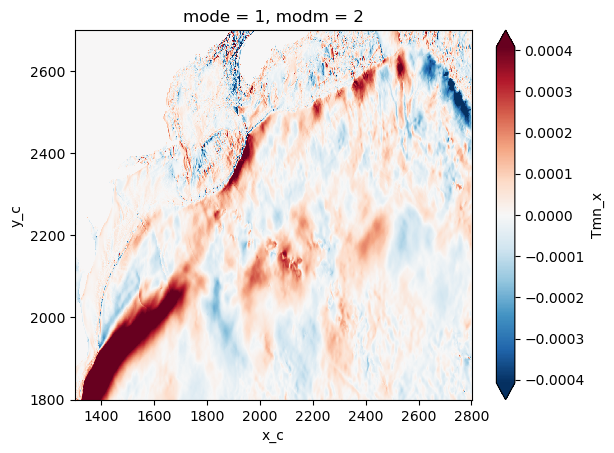

In [18]:
Tmn_x_N.plot(robust=True)